In [2]:
import os, cv2
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# find files for processing
def find_files(topdir):

    filepath = []
    for path, dirs, files in os.walk(topdir):
        #print path, dirs
        for fname in files:
            if fname.endswith('.jpg'):
                filepath.append(os.path.join(path, fname))
    
    return filepath

def rgb_to_single_band(infile):
    """
    Separate RGB image into individual single band 
    """
    img = cv2.imread(infile)
    
    blue = img[:, :, 0]
    green = img[:, :, 1]
    red = img[:, :, 2]
    
    return blue, green, red

def rgb_to_hsv(infile):
    """
    Convert RGB image to HSV space
    """
    ds_rgb = cv2.imread(infile)

    hsv = cv2.cvtColor(ds_rgb, cv2.COLOR_BGR2HSV)

    # separate output to arraies of hue, saturation and value   
    hue = hsv[:, :, 0]
    sat = hsv[:, :, 1]
    val = hsv[:, :, 2]

    return hsv, hue, sat, val

def hsb_to_rgb(infile):
    """
    conver HSV image back to RGB
    """
    
    bgrimg = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)    
    
    return bgrimg


def generate_blob_image(infile):
    """
    This is the step to generate a binary image for blob area only
    It looks white background speration works well and invers binary 
    was applied to obtain blob only area
    
    """
    img = cv2.imread(infile)
    
    # set threshold for white back ground 
    lower_white = np.array([220, 230, 220])
    upper_whtie = np.array([255, 255, 255])

    #mask_blue = cv2.inRange(img, lower_blue, upper_blue)
    mask_white = cv2.inRange(img, lower_white, upper_whtie)

    #result_blue = cv2.bitwise_and(img, img, mask=mask_blue)
    result_white = cv2.bitwise_and(img, img, mask=mask_white)

    # convert white background image to gray scale
    gray_image = cv2.cvtColor(result_white, cv2.COLOR_BGR2GRAY)

    # convert gray scale image to binary image and create background and blobs binary images
    ret, background = cv2.threshold(gray_image, 220, 255, cv2.THRESH_BINARY)
    ret, blobs = cv2.threshold(gray_image, 220, 255, cv2.THRESH_BINARY_INV)

    # remove tiny noisy pixel
    kernel = np.ones((2, 2), np.uint8)
    blobs_clean = cv2.morphologyEx(blobs, cv2.MORPH_OPEN, kernel)
    
    return blobs_clean


def divide_sections_compute_percentage(blob_image):
    """
    This is a step to divide blob image (in binary) into four sections
    
    --------
    Q1 | Q2
    --------
    Q3 | Q4
    --------
    Label is located at the lower bottom of the Q4 section and it must be excluded 
    for the computation
    
    """

    # get image size
    h, w = blob_image.shape[:2]
    #print ('height: ', h)
    #print ('width: ', w)

    # divide image into four section
    bh = h // 2
    bw = w // 2
    #print (bh)
    #print (bw)

    first_quarter = blob_image[:bh, :bw]
    second_quarter = blob_image[:bh, bw:]
    third_quarter = blob_image[bh:, :bw]
    fourth_quarter = blob_image[bh:, bw:]

    ###### make labeled area to zero #####
    fourth_quarter[2672:, 999:] = 0

    # obtain number of pixels in the masked area
    labeled_area = fourth_quarter[2672:, 999:]
    label_rows, label_cols = labeled_area.shape[:2]
    #print (label_rows, label_cols)
    label_area_pixels = label_rows * label_cols
    #print (label_area_pixels)

    # compute statistics of each quadrats
    total_pixel_counts = bh * bw
    blob_pixels_q1 = np.count_nonzero(first_quarter)
    pct_blob_q1 = round (100 * (blob_pixels_q1 / total_pixel_counts), 2)

    blob_pixels_q2 = np.count_nonzero(second_quarter)
    pct_blob_q2 = round (100 * (blob_pixels_q2 / total_pixel_counts), 2)

    blob_pixels_q3 = np.count_nonzero(third_quarter)
    pct_blob_q3 = round (100 * (blob_pixels_q3 / total_pixel_counts), 2)

    ##### fourth quarter is spectial case due to the label #####
    blob_pixels_q4 = np.count_nonzero(fourth_quarter)
    total_pixel_counts_q4 = total_pixel_counts - label_area_pixels
    pct_blob_q4 = round (100 * (blob_pixels_q4 / total_pixel_counts_q4), 2)

    return pct_blob_q1, pct_blob_q2, pct_blob_q3, pct_blob_q4

def main(topdir):
    
    filepath = find_files(topdir)
    
    # make output 
    percent_section_q1 = []
    percent_section_q2 = []
    percent_section_q3 = []
    percent_section_q4 = []
    fnames = []
    
    for f in filepath:
        
        blob = generate_blob_image(f)
        
        pctq1, pctq2, pctq3, pctq4 = divide_sections_compute_percentage(blob)
        
        percent_section_q1.append(pctq1)
        percent_section_q2.append(pctq2)
        percent_section_q3.append(pctq3)
        percent_section_q4.append(pctq4)
        fname = os.path.basename(f)
        
        print ('Computation done for file %s' %(fname))
        
        fnames.append(fname)
        
    df = pd.DataFrame({'Image Name': fnames, 
                       'Q1': percent_section_q1, 
                        'Q2': percent_section_q2, 
                        'Q3': percent_section_q3, 
                        'Q4': percent_section_q4})
    
    
    out_file = os.path.join(os.path.dirname(topdir), 'out.csv')
    df.to_csv(out_file, index = False)        


In [5]:
topdir = '/data'
main(topdir)

start_time = time.time()
elaspsed_time_secs = time.time() - start_time
hours, rest = divmod(elaspsed_time_secs,3600)
minutes, seconds = divmod(rest, 60)

print ("Execution took: " , hours, "hrs", minutes, "min", seconds, "secs")

Computation done for file spray_1.jpg
Computation done for file spray_3.jpg
Computation done for file spray_2.jpg
Execution took:  0.0 hrs 0.0 min 3.0040740966796875e-05 secs


In [6]:
blob_image = generate_blob_image(os.path.join(topdir, 'spray_1.jpg'))

In [7]:
blob_image.shape

(6534, 4925)

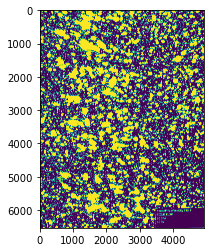

In [8]:
plt.imshow(blob_image)

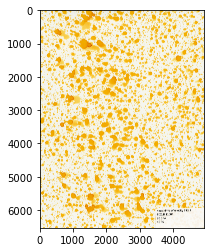

In [11]:
plt.imshow(cv2.imread(os.path.join(topdir, 'spray_1.jpg')))